In [2]:
%run ../draw_functions.py
%run ../kstest.py

In [3]:
from draw_functions import *
from kstest import *

In [4]:
#read csv
df = pd.read_csv('../csv/MX124012714X801.csv')

#ajout du slope
df['slope'] = df.groupby('ResultCurve_id').apply(lambda group: group['xvalue'].diff() / group['xtime'].diff(), include_groups=False).reset_index(level=0, drop=True)
df_02_08 = df[(df['xtime'] >= 0.2) & (df['xtime'] <= 0.8)]
df

,ResultCurve_id,xtime,xvalue,Batch,Sample_Code,slope
0,A8A65789-07F3-43E7-8955-0ECE09449E46,0.010000,1.118552,140901B,OQ19TOZU,NaN
1,A8A65789-07F3-43E7-8955-0ECE09449E46,0.020000,1.321925,140901B,OQ19TOZU,20.337301
2,A8A65789-07F3-43E7-8955-0ECE09449E46,0.047600,1.341810,140901B,OQ19TOZU,0.720484
3,A8A65789-07F3-43E7-8955-0ECE09449E46,0.070000,1.355820,140901B,OQ19TOZU,0.625453
4,A8A65789-07F3-43E7-8955-0ECE09449E46,0.095200,1.298876,140901B,OQ19TOZU,-2.259700
...,...,...,...,...,...,...
4195,A41DCD52-5B8E-4FC8-BBE8-A90199251540,0.248333,1.299328,142102B,OQ19U570,1.129850
4196,A41DCD52-5B8E-4FC8-BBE8-A90199251540,0.287600,1.498558,142102B,OQ19U570,5.073775
4197,A41DCD52-5B8E-4FC8-BBE8-A90199251540,0.288333,1.502701,142102B,OQ19U570,5.649250
4198,A41DCD52-5B8E-4FC8-BBE8-A90199251540,0.318333,1.728671,142102B,OQ19U570,7.532334


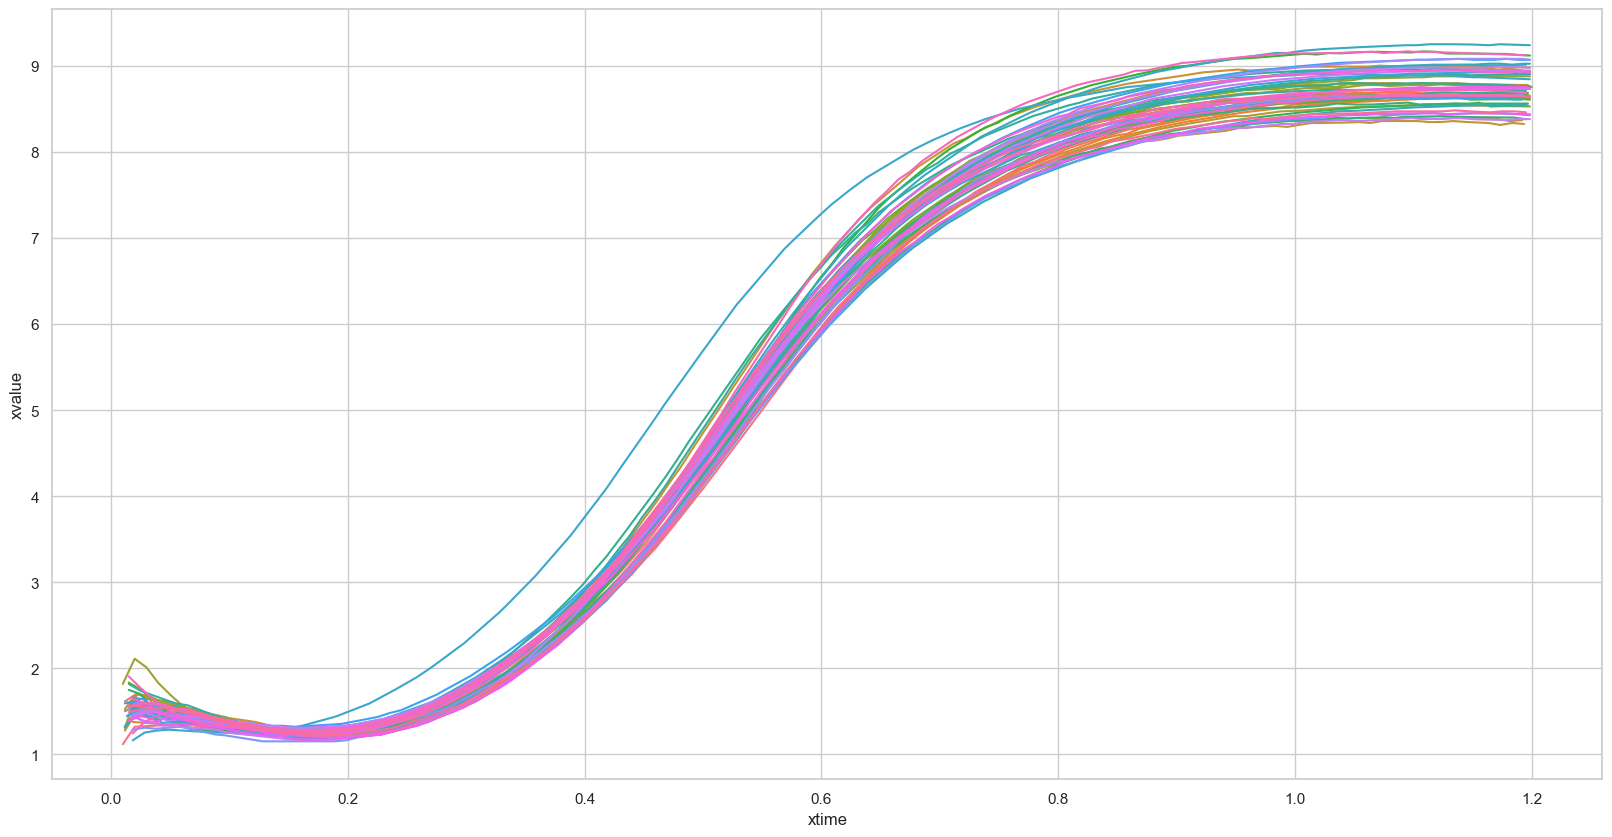

In [5]:
dessiner_commande(df)

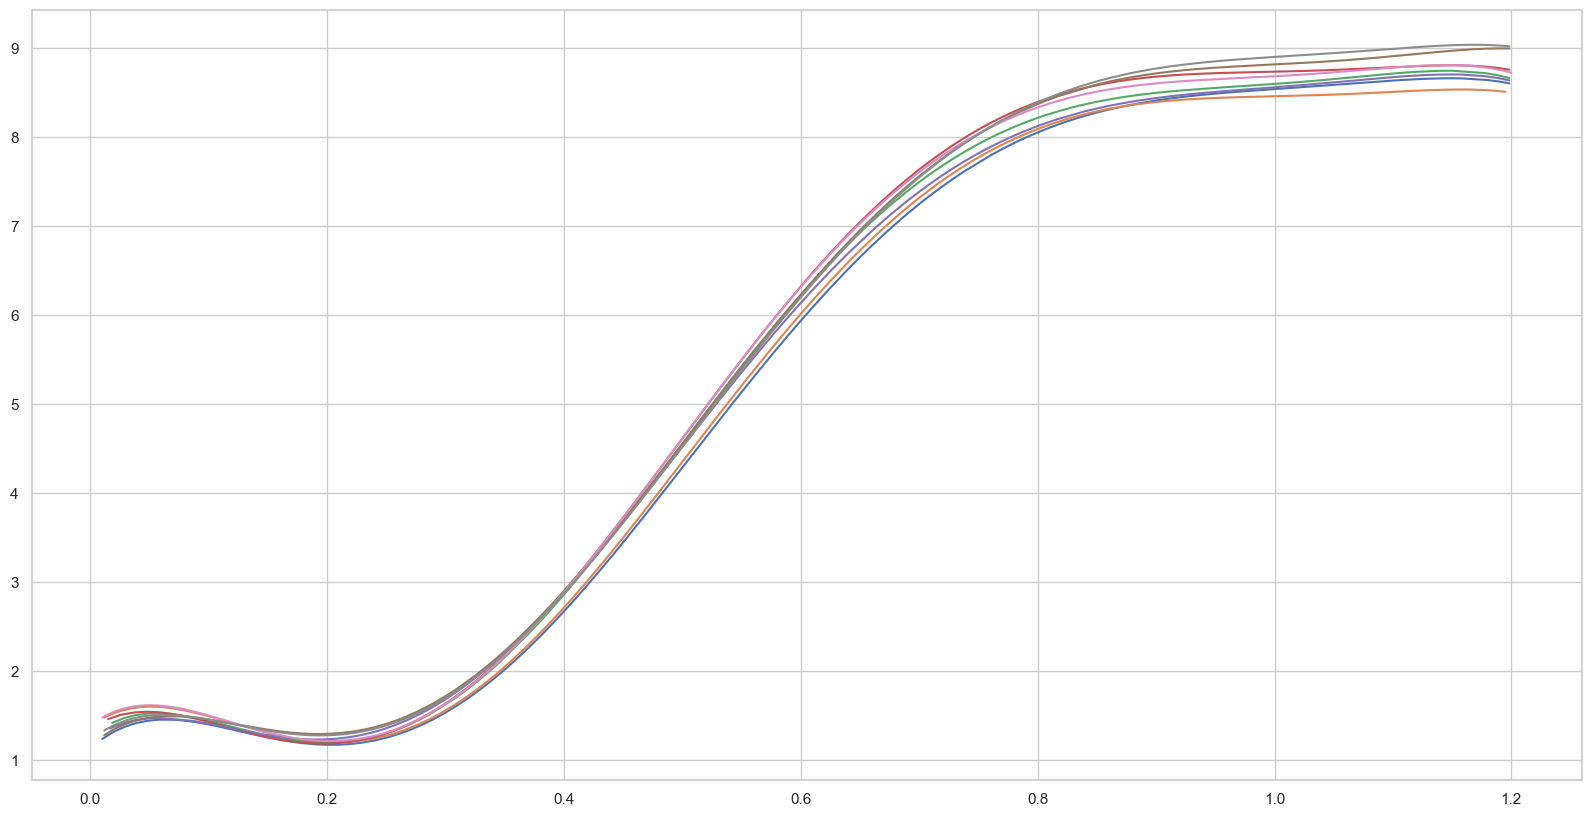

In [6]:
dessiner_commande(df,degree=6)

## Analyse des pentes

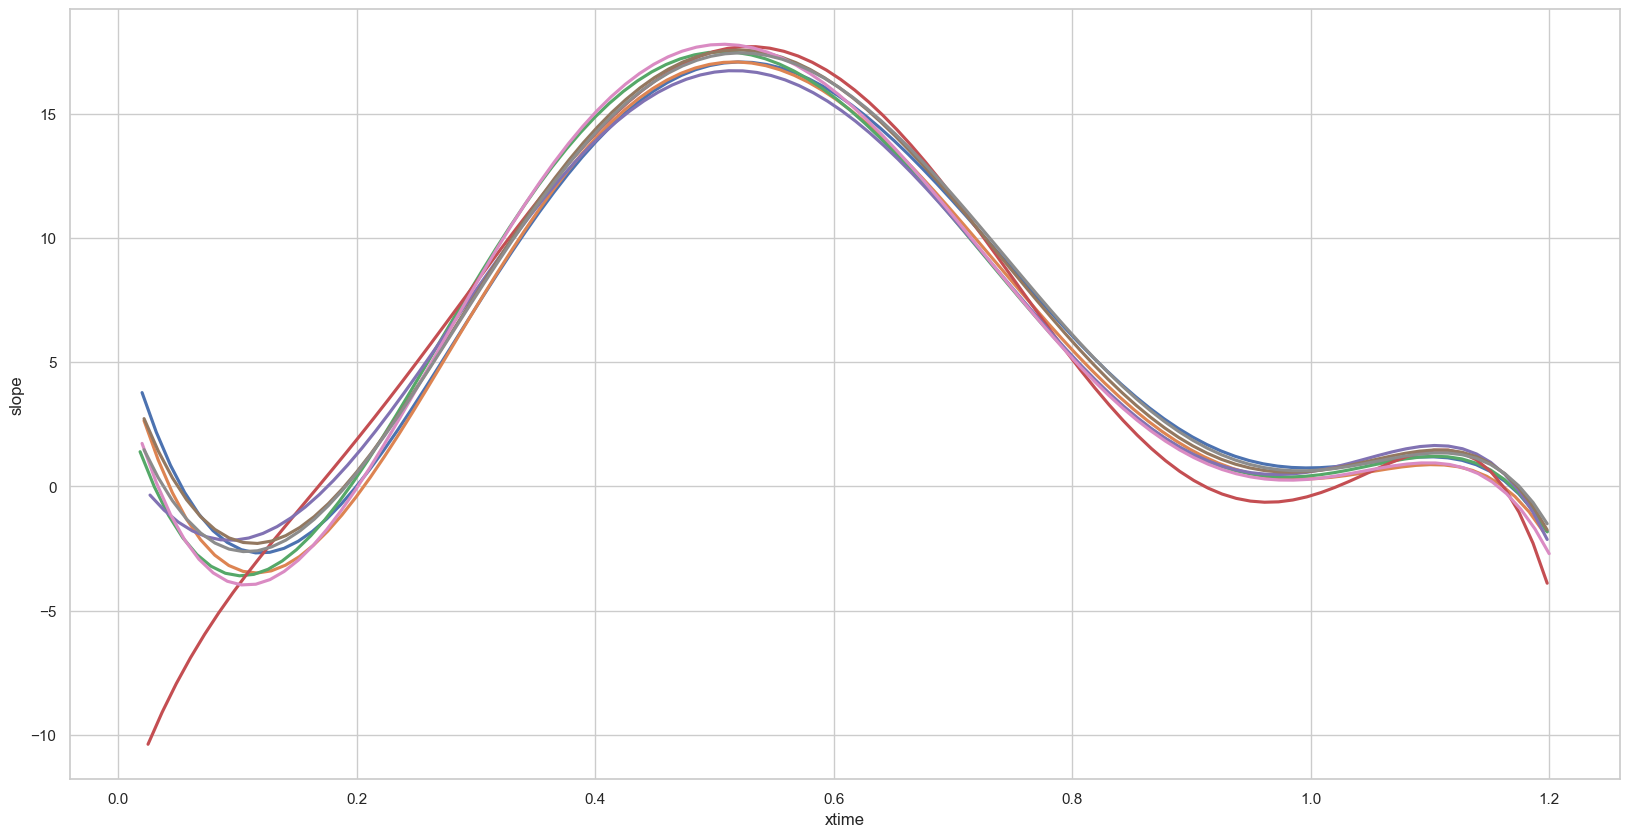

In [7]:
dessiner_commande_slope(df, 6 ,unified=True)

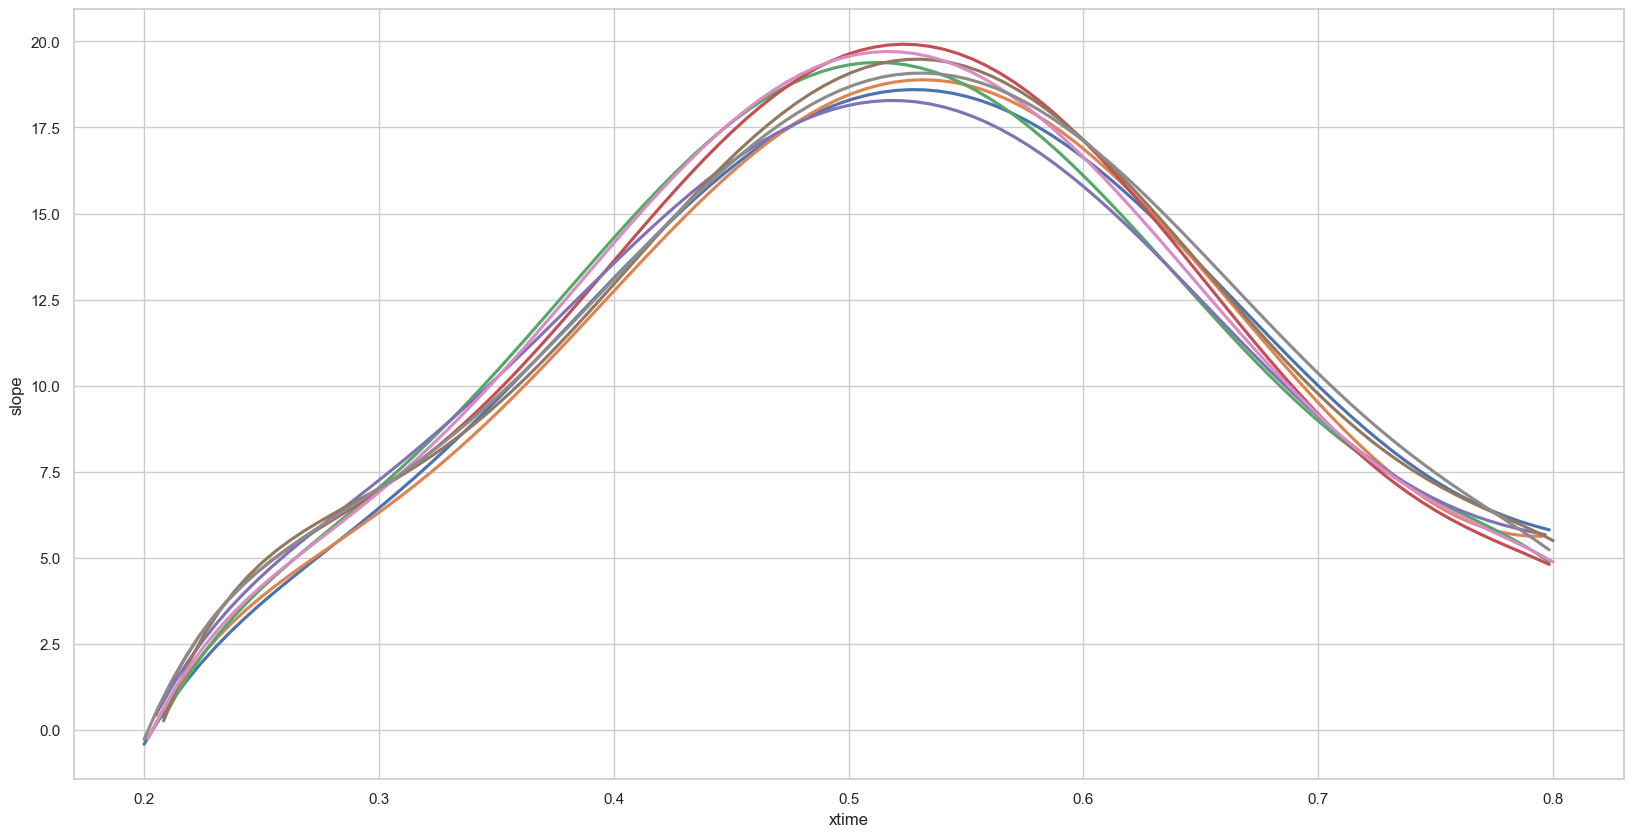

In [8]:
dessiner_commande_slope(df_02_08, 6 ,unified=True)

- Batch 151808B: 4.641590720017243
- Batch 145605B: 4.558771781367516
- Batch 150606B: 4.507895278403613
- Batch 143203B: 3.0620721883429463
- Batch 140901B: 2.540318854068067
- Batch 151107B: 2.1801016998514187
- Batch 142102B: 2.140915660739006
- Batch 144404B: 1.936058769724705


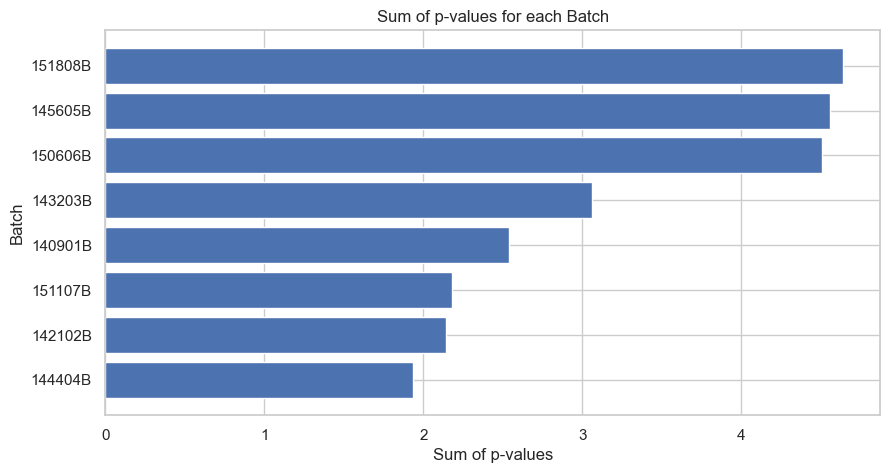

In [9]:
batch_pvalues = ks_test_slope(df, 6)

visualiser_pvalue(batch_pvalues, log=True)

- Batch 150606B: 11.516454431559254
- Batch 151808B: 7.364952669097818
- Batch 145605B: 6.977204123836232
- Batch 140901B: 4.439522788302896
- Batch 144404B: 4.401229954845238
- Batch 151107B: 4.37970880732304
- Batch 142102B: 3.830347693666888
- Batch 143203B: 3.668365094997964


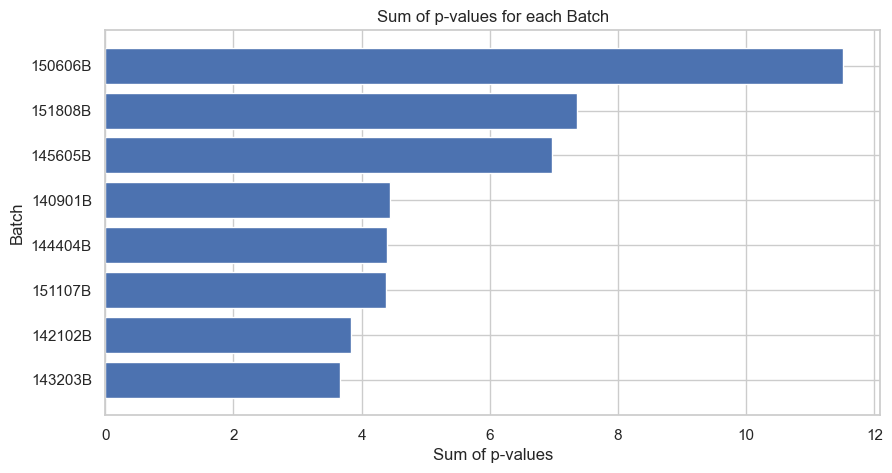

In [10]:
batch_pvalues = ks_test_value(df, 6)

visualiser_pvalue(batch_pvalues, log=True)

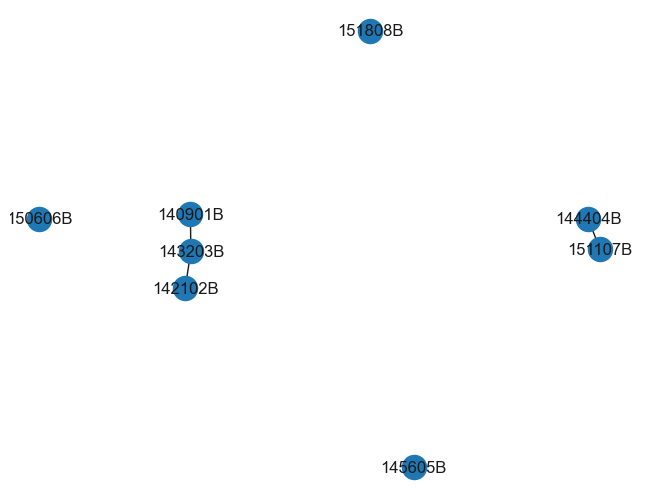

In [11]:
import networkx as nx

# Create an empty graph
G = nx.Graph()

# Add nodes for each batch
for batch in df['Batch'].unique():
    G.add_node(batch)

# Calculate the KS test p-value for each pair of batches and add edges
for batch1, batch2 in itertools.combinations(df['Batch'].unique(), 2):
    pvalue = Batch_ks_value_test(df, batch1, batch2, degree=6)
    if not pd.isna(pvalue) and pvalue > 0.05:
        # Use the inverse of the p-value as the weight (distance)
        G.add_edge(batch1, batch2)

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True)

plt.show()

In [12]:
# Trouver le xtime correspondant au max de la pente pour chaque groupe
max_slope_xtime = df_02_08.loc[df_02_08.groupby('Batch')['slope'].idxmax()]['xtime']

# Calculer la différence entre le max et le min des xtime
max_diff = max_slope_xtime.max() - max_slope_xtime.min()

print("La plus grande différence de temps entre les max des pentes des différentes batch est :", round(max_diff*60,3), "secondes")

La plus grande différence de temps entre les max des pentes des différentes batch est : 4.817 secondes


In [5]:
# Trouver le xtime correspondant au max de la pente pour chaque groupe
max_slope_sample_xtime = df_02_08.loc[df_02_08.groupby('Sample_Code')['slope'].idxmax()][['Batch', 'xtime']].set_index('Batch')['xtime']
max_slope_batch_xtime = max_slope_sample_xtime.groupby('Batch').median()

# Calculer la médiane de xtime pour chaque groupe
median_xtime = max_slope_sample_xtime.median()

# Calculer la différence entre le xtime du max de la pente et la médiane de xtime pour chaque groupe
diff = max_slope_batch_xtime - median_xtime

# Sort the differences by their absolute values in descending order
diff_sorted = diff.abs().sort_values(ascending=False)

# Print the differences in the sorted order
for batch in diff_sorted.index:
    print(f"La différence de temps entre le max de la pente et la médiane pour le batch {batch} est : {round(diff_sorted[batch]*60,3)} seconde")

La différence de temps entre le max de la pente et la médiane pour le batch 140901B est : 0.843 seconde
La différence de temps entre le max de la pente et la médiane pour le batch 151808B est : 0.36 seconde
La différence de temps entre le max de la pente et la médiane pour le batch 144404B est : 0.192 seconde
La différence de temps entre le max de la pente et la médiane pour le batch 150606B est : 0.176 seconde
La différence de temps entre le max de la pente et la médiane pour le batch 145605B est : 0.132 seconde
La différence de temps entre le max de la pente et la médiane pour le batch 151107B est : 0.125 seconde
La différence de temps entre le max de la pente et la médiane pour le batch 142102B est : 0.108 seconde
La différence de temps entre le max de la pente et la médiane pour le batch 143203B est : 0.0 seconde


In [6]:
round(np.std(max_slope_sample_xtime)*1000,2)

27.9

In [7]:
round(np.std(max_slope_batch_xtime)*1000,2)

5.73